In [4]:
# Network Data Science 
import networkx as nx

# Data Wrangling
import numpy as np
import pandas as pd

# Network Data Analysis 
import networkx as nx
import geonetworkx as gnx

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
from matplotlib import colors
import netwulf as nw
%pylab inline

# Geo-Spatial Data Analysis
import geopandas as gpd
from shapely.geometry import Point, LineString

# Other Utilities
from operator import itemgetter
from collections import defaultdict
import random 
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')

# Custom Modules
import digital_epidemiology as depi

# Reload Custom Modules
from importlib import reload
depi = reload(depi)

Populating the interactive namespace from numpy and matplotlib


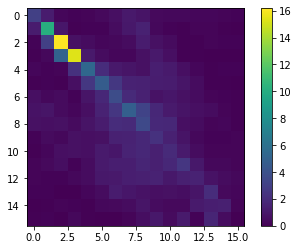

In [5]:
# Load contact data 
contact_data = pd.read_csv("/Users/Pit/GitHub/DigitalEpidemiologyProject/Data/CSV/2020/ContactMatrixAllLocations.csv")

# Construct contact graph
contact_graph = nx.from_numpy_array(contact_data.to_numpy())

# Display weighted edges
###contact_graph.edges(data=True)

# Visualize the contact graph
#nw.visualize(contact_graph)

# Create the contact matrix 
contact_matrix = contact_data.to_numpy()

# Normalize the contact matrix 
normalized_contact_matrix = normalize(contact_data.to_numpy(), axis=1, norm='l1')

# Visualize the contact matrix 
plt.imshow(contact_matrix)
plt.colorbar()
plt.show()

In [ ]:

def network_SIR_multirun_simulation(G, nrun, lambd, mu):
    """
    Multi-run stochastic SIR simulation. 
    """
    I_dict = defaultdict(list)   # Define the time series dictionary for I 
    Irun = []                    # Define the multi-run list of lists for I 
    
    for run in range(0,nrun):
        # Create a dictionary of nodal infection/disease states s.t. S=0, I=1, R=-1
        G.disease_status = {} 
    
        # Create a list of infected notes 
        I_nodes = []
    
        # Choose a seed
        node_list = []
        deg = dict(G.degree())
        for i in sorted(deg.items(), key = itemgetter(1)):
            node_list.append(i[0])
        seed = node_list[-1]
    
        # Initialize the network
        I_nodes.append(seed)
    
        for n in G.nodes():
            if n in I_nodes:
                # Infected
                G.disease_status[n] = 1 
            else:
                # Susceptible
                G.disease_status[n] = 0 
            
        t = 0                          # Initialize the clock
    
        I_list = []                    # Define the single-run list for I 
        I_list.append(len(I_nodes))    # Initialize the single-run list for I
        I_dict[t].append(I_nodes)      # Initialize the time series dictionary for I
    
        # Implement the dynamical model 
        while len(I_nodes)>0:
    
            # Transmission dynamics (S -> I)
            for i in I_nodes:                           # For any infected node 
                for j in G.neighbors(i):                # For any of its neighbours 
                    if G.disease_status[j] == 0:        # If it's S, 
                        p = np.random.random()          # then infect it with probability lambda
                        if p < lambd:
                            G.disease_status[j] = 1
                
            # Recovery dynamics (I -> R)
            for k in I_nodes:                           # For any infected node 
                p = np.random.random()                  # It recovers with probability mu
                if p < mu:
                    G.disease_status[k] = -1
    
            # Update infected nodes
            I_nodes = []
            for node in G.nodes():
                if G.disease_status[node] == 1:
                    I_nodes.append(node)
        
            t += 1
            # Register the prevalence for each time step
            #I_graph.append(len(infected_nodes))
            I_list.append(len(I_nodes))
            I_dict[t].append(len(I_nodes))
        
        Irun.append(I_list)
    return Irun 



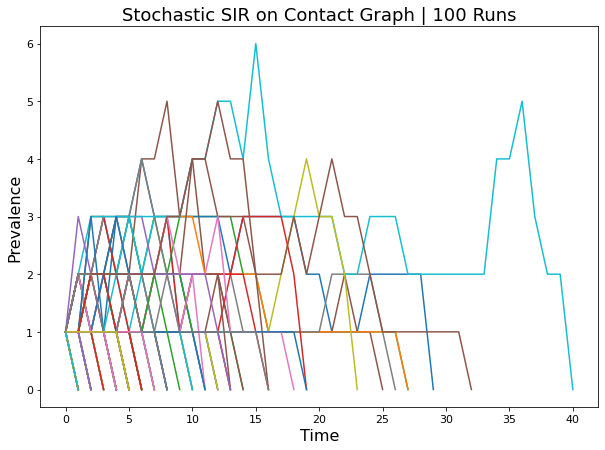

In [7]:
# Model Parameters
mu = 0.2           # Recovery rate 
lambd = 0.01       # Transmission rate per contact

# Simulation Parameters
nrun = 100        # Number of runs
 
# Multi-Run Simulation
runs = depi.network_SIR_multirun_simulation(contact_graph, nrun = nrun, lambd = lambd, mu = mu)

# Set figure size 
plt.figure(figsize=(10,7))
plt.title('Stochastic SIR on Contact Graph | 100 Runs', fontsize = 18)

# Plot the ensemble of trajectories
depi.plot_ensemble(runs)     